In [1]:
# Do analyst recommendations correlate with stock performance?
import pandas as pd
import numpy as np
import yfinance as yf
import warnings
warnings.filterwarnings("ignore")
import datetime
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import sqlite3
from IPython.display import display
from sklearn.metrics import r2_score
import math
pd.set_option('display.max_columns',500)

In [2]:
stock_tickers = ['FB','AAPL','AMZN','NFLX','GOOGL','DIS','CBRL','HBI','XOM']
period = '5y'

In [5]:
def process_individual_stock(stock_ticker,period='5y',days_out=180,color_method='Auto',\
                             qlow=0.15,qhigh=0.85,vmin=2.75,vmax=3.75,\
                             returns_method='Period',\
                             min_returns=5,split_size=50):
    # Prepare yfinance
    print('Results for: '+stock_ticker)
    stock=yf.Ticker(stock_ticker)
    
    # Get historical trading data
    history=stock.history(period=period)
    history
    
    # Get recommendations
    days_out = days_out
    recommendations=stock.recommendations.reset_index().sort_values(by=['Firm','Date'])
    recommendations['Next Recommendation']=recommendations.groupby('Firm')['Date'].shift(-1)
    recommendations[str(days_out)+' Days From']=recommendations['Date']+pd.Timedelta(days=days_out)
    recommendations['Good Until']=recommendations\
        [['Next Recommendation',str(days_out)+' Days From']]\
            .max(axis=1) # Define how long a recommendation lasts for - lowest of [days_out] or
                # [Until a new recommendation by that firm]

    # Process the recommendation values
    print('Recommendation values: '\
          +str(sorted(recommendations['To Grade'].dropna().unique()))) # Print out the unique recommendation grades
    assign_values = {'Buy':4, 'Equal-Weight':3, 'Hold':3, 'Market Perform':3, 'Neutral':3,
       'Outperform':4, 'Overweight':4, 'Peer Perform':3, 'Positive':4, 'Reduce':2,
       'Sector Perform':3, 'Sector Weight':3, 'Sell':1, 'Strong Buy':5, 'Underperform':1,
       'Underweight':1} # Create numeric representations of the recommendations
    recommendations['Assigned Value']=\
    recommendations['To Grade'].replace(assign_values) # Give the numeric representations a column
    
    # Store the dataframes in sqlite memory
    conn = sqlite3.connect(':memory:')
    history.to_sql('history', conn, index=True)
    recommendations.to_sql('recommendations', conn, index=False)
    
    # Get average analyst assigned scores by day using SQL
    qry = '''
    select h.open, h.high, h.low, h.close, h.volume, date(h.date) as Date, avg(r.'assigned value') as 'Average Assigned Value'
    from history h
    left join ( 
    select * from recommendations r 
    where r.firm in 
    (select firm from recommendations group by firm having count(date)>=5)
        -- Join recommendations, but only for firms with at least 5 recommendations
    ) r
    on date(h.date) between date(r.date) and date(r.'good until')
    group by h.open, h.high, h.low, h.close, h.volume, date(h.date)
        '''
    df = pd.read_sql_query(qry, conn).sort_values(by='Date')
    df['Date']=pd.to_datetime(df['Date'])

        
    # Make a plot with background color estimating recommendation sentiment for the periods
    # This considers the average recommendation overall
    fig,ax = plt.subplots()
    df.plot(figsize=(16,16),x='Date',y='Close',ax=ax)
    # # Originally used a list color map but change to a scalar map
    colormap=colors.LinearSegmentedColormap.from_list('custom',['Red','Yellow','Green'])
    # vmin, vmax = 2.5, 4.5 # Manual color definition
    if color_method == 'Auto':
        qlow = qlow
        qhigh = qhigh
        vmin = df['Average Assigned Value'].quantile(qlow) # Color definition using quantiles (low)
        vmax = df['Average Assigned Value'].quantile(qhigh) # Color definition using quantiles (high)
    elif color_method == 'Manual':
        vmin = vmin
        vmax = vmax
    else:
        print('Error: Please choose Auto or Manual to define your color scheme.')
        return
    normalize = colors.Normalize(vmin=vmin,vmax=vmax)
    scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
    for idx, row in df.iterrows():
        ax.axvspan(row['Date'],row['Date']+pd.DateOffset(days=1),\
                   alpha=0.2,color=scalarmappaple.to_rgba(row['Average Assigned Value']))
    cbar=plt.colorbar(scalarmappaple,label='Average Analyst Recommendation',extend='both',fraction=0.046, pad=0.04)
    plt.show()
    
    # Get a correlation matrix of the current columns
    df['Returns']=(df['Close']-df['Close'].shift(1))/df['Close'].shift(1) # Day returns
    print('Correlation matrix for all data:')
    display(df.corr())
    
    if returns_method == 'Recommendation Moves':
        # Process the dataframe to get columns that can be grouped on the
                # analyst average recommendation to show how it affects returns
        df['Track Difference Up'] = np.where(df['Average Assigned Value']==df['Average Assigned Value'].shift(1),0,1)
        df['Track Difference Down'] = np.where(df['Average Assigned Value']==df['Average Assigned Value'].shift(-1),0,1)
        df['Track Difference Unique'] = df['Track Difference Up'].cumsum()
        df['First Open'] = np.where(df['Track Difference Up']==1,df['Open'],None)
        df['Last Close'] = np.where(df['Track Difference Down']==1,df['Close'],None)

        # Get a grouped dataframe with returns data by average analyst recommendation
        returns_df = df.groupby(['Track Difference Unique','Average Assigned Value'])\
            .agg({'First Open':'min','Last Close':'max','Returns':'count'}).reset_index()
        returns_df['Total Return Fraction']=returns_df['Last Close']/returns_df['First Open']
        returns_df['Daily Return']=100*\
            ((returns_df['Total Return Fraction']**(1/returns_df['Returns']))-1) # Get the daily 
                            # return rate for the period by taking the n-th root of n-day
                                # cumulative stock movements and subtracting 1 (remember the compound interest equation)

        # Create a dataframe that has at least the minimum days
                    # (otherwise 1-day moves could yield high variance, potentially leading to false conclusions)
                    # Plot and correlate returns and ratings of that dataframe
        min_returns = min_returns
        min_returns_df = returns_df[returns_df['Returns']>=min_returns]
        min_returns_df.plot(x='Average Assigned Value',y='Daily Return',kind='scatter',figsize=(12,12))
        m,b = np.polyfit(x=min_returns_df['Average Assigned Value'],y=min_returns_df['Daily Return'], deg=1)
        plt.plot(min_returns_df['Average Assigned Value'],min_returns_df['Average Assigned Value']*m+b)
        title = 'R2 Score: '+str(round(r2_score(min_returns_df['Daily Return'],min_returns_df['Average Assigned Value']*m+b),4))
        plt.title(title)
        plt.show()
        print('Correlation matrix for processed returns data:')
        display(min_returns_df.corr())
#         display(min_returns_df)
    
    elif returns_method == 'Period':
        # Split the stock into periods and find the return rate during that period as well as the average rating
        split_size = split_size
        split_bins = math.ceil(df.shape[0]/split_size)
        df = pd.read_sql_query(qry, conn).sort_values(by='Date')
        df['Date']=pd.to_datetime(df['Date'])
        df['Period Group'] = pd.cut(df['Date'],split_bins)
        df['First Open'] = df.groupby('Period Group').head(1)['Open']
        df['Last Close'] = df.groupby('Period Group').tail(1)['Close']
#         display(df)
        
        # Get a grouped dataframe with returns data for that period to compare against average analyst recommendation
        returns_df = df.groupby(['Period Group'])\
        .agg({'First Open':'min','Last Close':'max','Date':'count','Average Assigned Value':'mean'}).reset_index()
        returns_df['Total Return Fraction']=returns_df['Last Close']/returns_df['First Open']
        returns_df['Daily Return']=100*\
            ((returns_df['Total Return Fraction']**(1/returns_df['Date']))-100)-100 # Get the daily 
                            # return rate for the period by taking the n-th root of n-day
                                # cumulative stock movements and subtracting 1 (remember the compound interest equation)

        # Create a dataframe that has at least the minimum days. Get the return for each period bin.
                    # Then plot and correlate that dataframe
        min_returns_df = returns_df[returns_df['Date']\
                                    >=min(split_size-1,split_size*0.9)] # Each bin
                            # for plotting and correlation needs to be at least 90% the size of the split_size
        min_returns_df.plot(x='Average Assigned Value',y='Daily Return',kind='scatter',figsize=(12,12))
        m,b = np.polyfit(x=min_returns_df['Average Assigned Value'],y=min_returns_df['Daily Return'], deg=1)
        plt.plot(min_returns_df['Average Assigned Value'],min_returns_df['Average Assigned Value']*m+b)
        title = 'R2 Score: '+\
            str(round(r2_score(min_returns_df['Daily Return'],min_returns_df['Average Assigned Value']*m+b),4))
        plt.title(title)
        plt.show()
        print('Correlation matrix for processed returns data:')
        display(min_returns_df.corr())
#         display(min_returns_df)
    
    else:
        print('Error: Please choose Period or Recommendation Moves as your method of returns analysis.')
        return
    
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

Results for: FB
Recommendation values: ['Buy', 'Equal-Weight', 'Equal-weight', 'Hold', 'Long-term Buy', 'Market Outperform', 'Market Perform', 'Mixed', 'Neutral', 'Outperform', 'Overweight', 'Positive', 'Reduce', 'Sector Perform', 'Sell', 'Strong Buy']


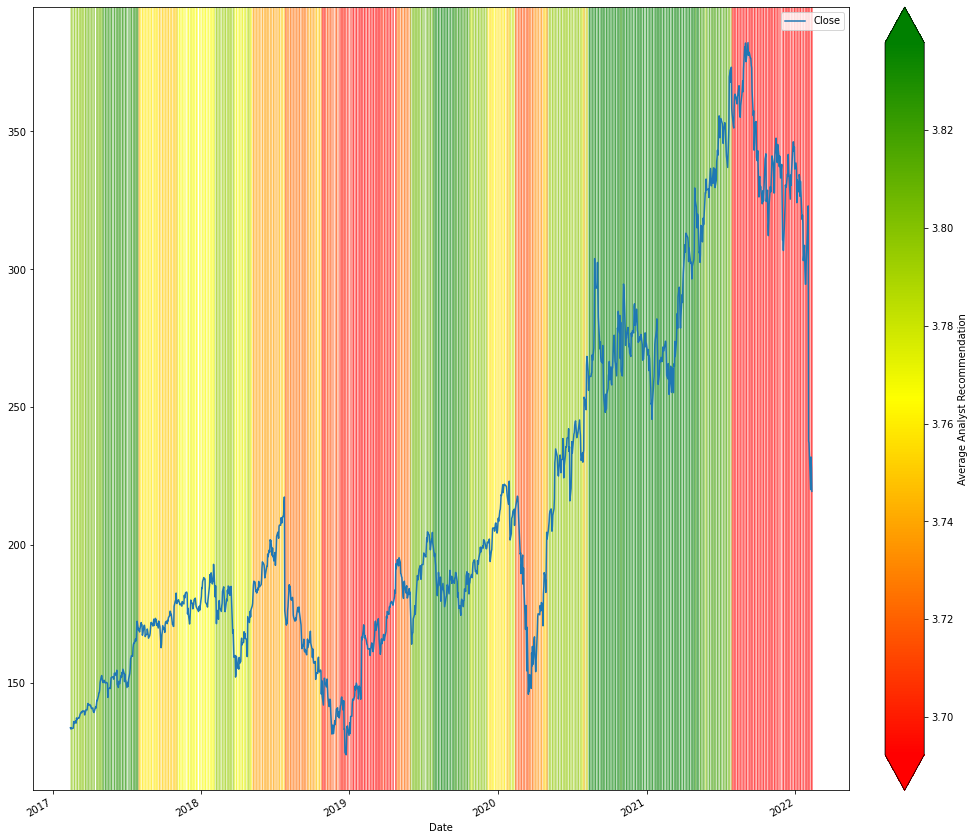

Correlation matrix for all data:


,Open,High,Low,Close,Volume,Average Assigned Value,Returns
Open,1.000000,0.999337,0.999241,0.998535,-0.063304,-0.068722,-0.010847
High,0.999337,1.000000,0.999082,0.999284,-0.052647,-0.069001,0.004893
Low,0.999241,0.999082,1.000000,0.999333,-0.077582,-0.068109,0.009535
Close,0.998535,0.999284,0.999333,1.000000,-0.066372,-0.068115,0.026853
Volume,-0.063304,-0.052647,-0.077582,-0.066372,1.000000,-0.142489,-0.197844
Average Assigned Value,-0.068722,-0.069001,-0.068109,-0.068115,-0.142489,1.000000,0.054450
Returns,-0.010847,0.004893,0.009535,0.026853,-0.197844,0.054450,1.000000


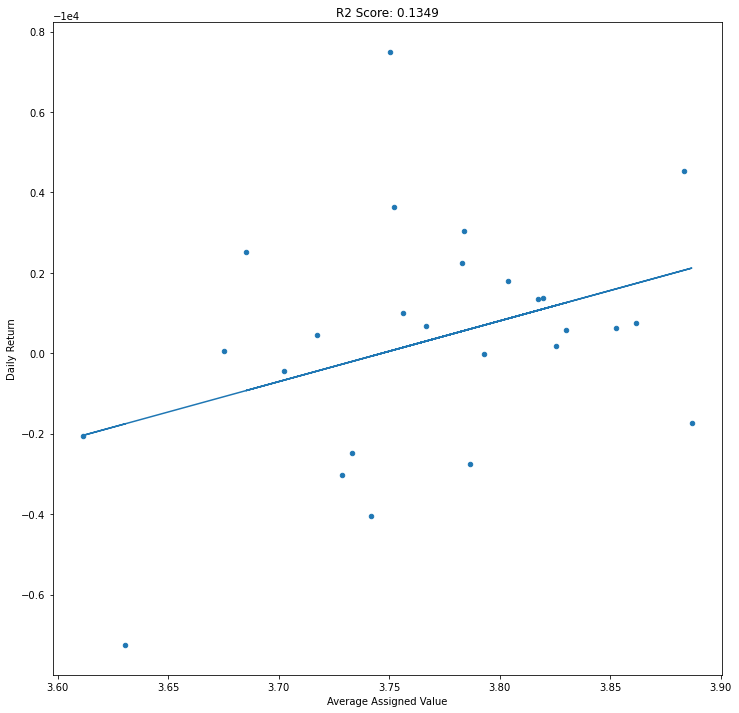

Correlation matrix for processed returns data:


,First Open,Last Close,Date,Average Assigned Value,Total Return Fraction,Daily Return
First Open,1.000000,0.873963,0.081924,-0.135033,-0.345843,-0.358245
Last Close,0.873963,1.000000,0.112967,0.096808,0.133991,0.128974
Date,0.081924,0.112967,1.000000,-0.101488,0.084709,0.062339
Average Assigned Value,-0.135033,0.096808,-0.101488,1.000000,0.334035,0.367245
Total Return Fraction,-0.345843,0.133991,0.084709,0.334035,1.000000,0.992729
Daily Return,-0.358245,0.128974,0.062339,0.367245,0.992729,1.000000


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Results for: AAPL
Recommendation values: ['', 'Buy', 'Equal-Weight', 'Equal-weight', 'Hold', 'Long-Term Buy', 'Long-term Buy', 'Market Outperform', 'Market Perform', 'Negative', 'Neutral', 'Outperform', 'Overweight', 'Peer Perform', 'Perform', 'Positive', 'Reduce', 'Sector Outperform', 'Sector Perform', 'Sector Weight', 'Sell', 'Strong Buy', 'Underperform', 'Underweight']


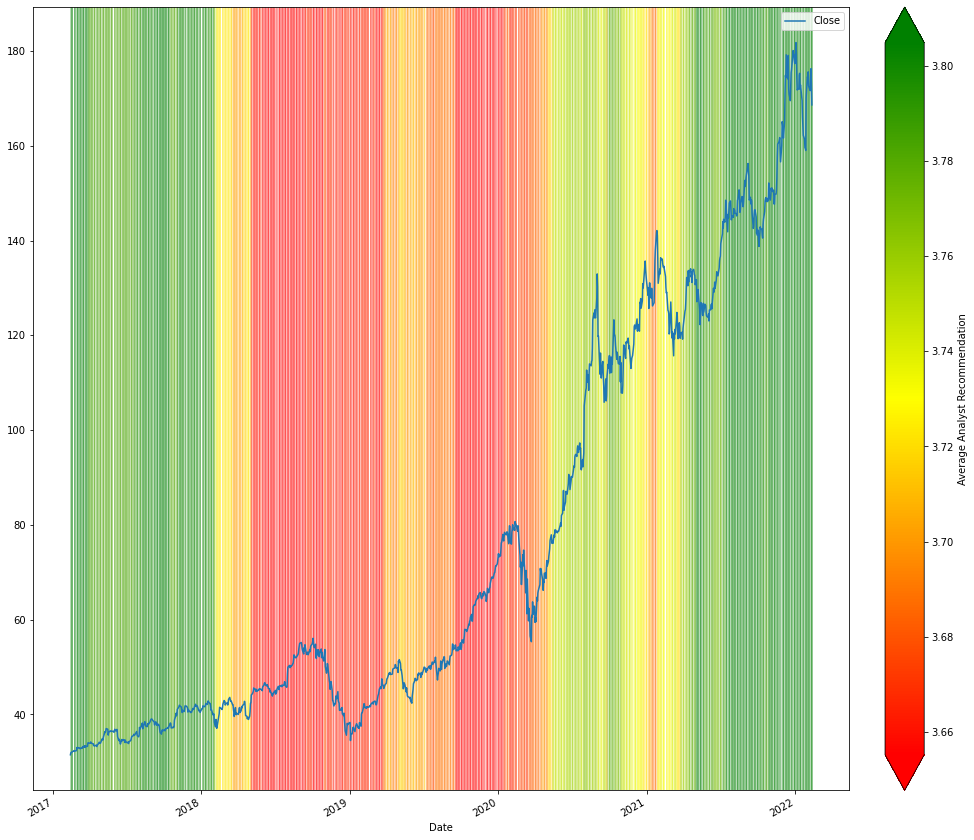

Correlation matrix for all data:


,Open,High,Low,Close,Volume,Average Assigned Value,Returns
Open,1.000000,0.999820,0.999745,0.999535,-0.154827,0.450036,0.005759
High,0.999820,1.000000,0.999690,0.999759,-0.147943,0.449105,0.013324
Low,0.999745,0.999690,1.000000,0.999763,-0.163883,0.451106,0.015162
Close,0.999535,0.999759,0.999763,1.000000,-0.156420,0.449826,0.026094
Volume,-0.154827,-0.147943,-0.163883,-0.156420,1.000000,-0.195679,-0.083344
Average Assigned Value,0.450036,0.449105,0.451106,0.449826,-0.195679,1.000000,-0.005452
Returns,0.005759,0.013324,0.015162,0.026094,-0.083344,-0.005452,1.000000


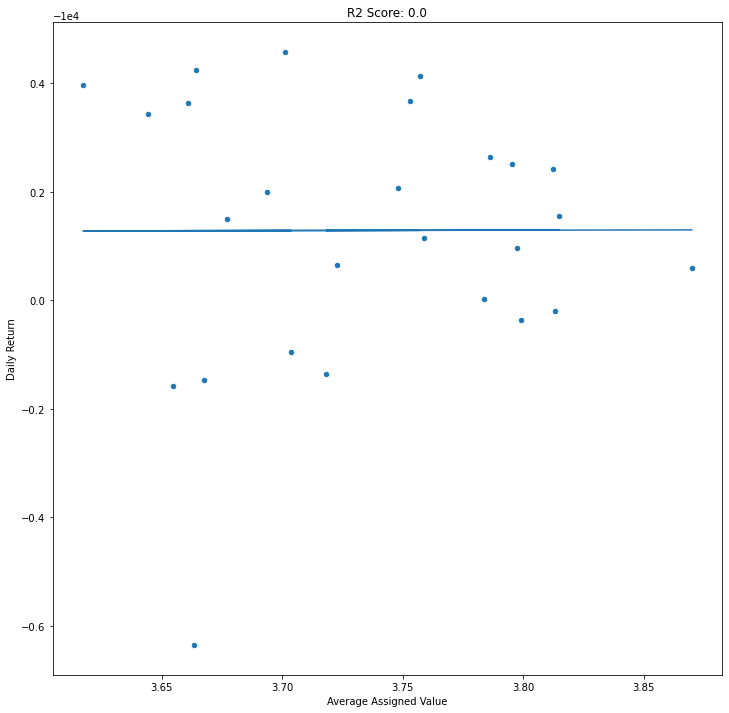

Correlation matrix for processed returns data:


,First Open,Last Close,Date,Average Assigned Value,Total Return Fraction,Daily Return
First Open,1.000000,0.983404,0.042407,0.460756,-0.017854,-0.002049
Last Close,0.983404,1.000000,0.110704,0.456328,0.149370,0.162359
Date,0.042407,0.110704,1.000000,0.163513,0.382632,0.410094
Average Assigned Value,0.460756,0.456328,0.163513,1.000000,-0.040477,0.001945
Total Return Fraction,-0.017854,0.149370,0.382632,-0.040477,1.000000,0.994927
Daily Return,-0.002049,0.162359,0.410094,0.001945,0.994927,1.000000


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Results for: AMZN
Recommendation values: ['', 'Buy', 'Equal-Weight', 'Fair Value', 'Hold', 'Market Outperform', 'Market Perform', 'Neutral', 'Outperform', 'Overweight', 'Peer Perform', 'Perform', 'Positive', 'Sector Weight', 'Sell', 'Strong Buy']


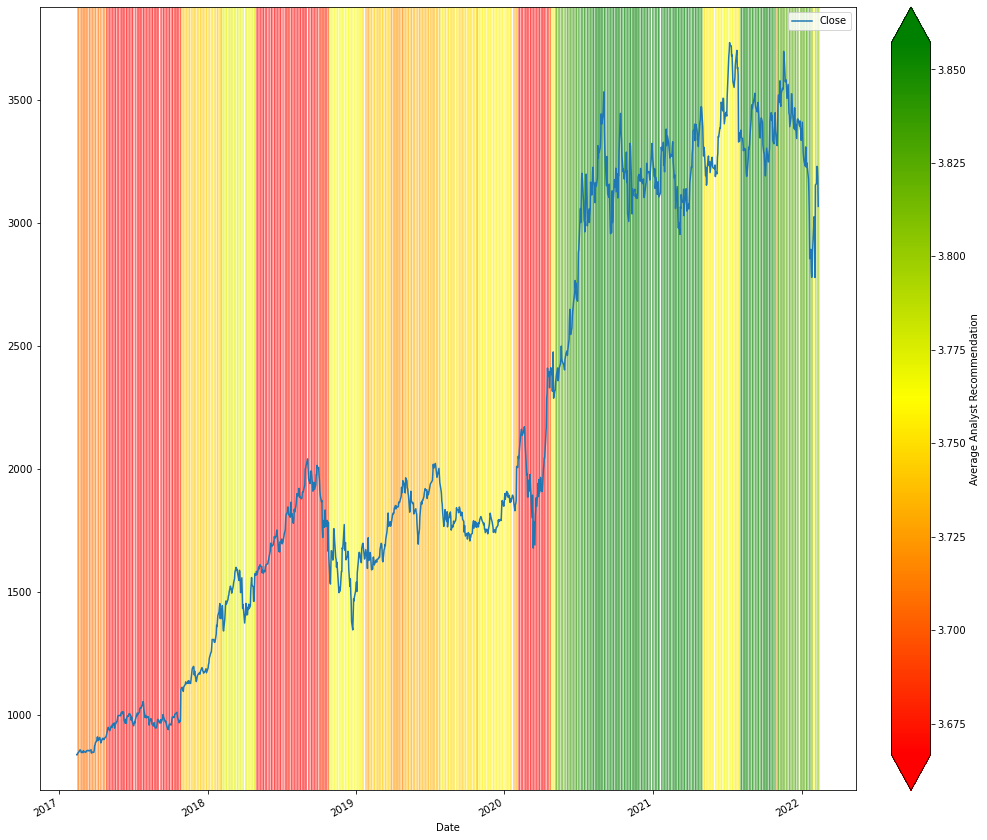

Correlation matrix for all data:


,Open,High,Low,Close,Volume,Average Assigned Value,Returns
Open,1.000000,0.999658,0.999546,0.999145,-0.079650,0.774813,-0.031244
High,0.999658,1.000000,0.999446,0.999589,-0.070134,0.775404,-0.018172
Low,0.999546,0.999446,1.000000,0.999598,-0.092746,0.773281,-0.015979
Close,0.999145,0.999589,0.999598,1.000000,-0.081554,0.774314,-0.001088
Volume,-0.079650,-0.070134,-0.092746,-0.081554,1.000000,-0.043937,-0.020691
Average Assigned Value,0.774813,0.775404,0.773281,0.774314,-0.043937,1.000000,-0.008982
Returns,-0.031244,-0.018172,-0.015979,-0.001088,-0.020691,-0.008982,1.000000


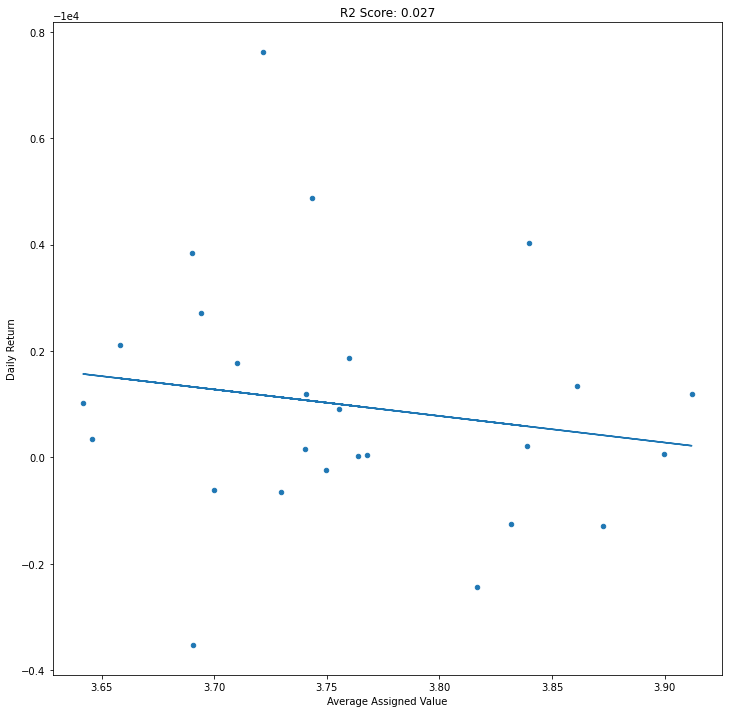

Correlation matrix for processed returns data:


,First Open,Last Close,Date,Average Assigned Value,Total Return Fraction,Daily Return
First Open,1.000000,0.963178,0.052546,0.813092,-0.319440,-0.331624
Last Close,0.963178,1.000000,0.064615,0.810110,-0.066512,-0.077876
Date,0.052546,0.064615,1.000000,-0.072081,0.038484,0.022660
Average Assigned Value,0.813092,0.810110,-0.072081,1.000000,-0.169938,-0.164425
Total Return Fraction,-0.319440,-0.066512,0.038484,-0.169938,1.000000,0.995695
Daily Return,-0.331624,-0.077876,0.022660,-0.164425,0.995695,1.000000


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Results for: NFLX
Recommendation values: ['', 'Average', 'Below Average', 'Buy', 'Equal-Weight', 'Equal-weight', 'Fair Value', 'Hold', 'In-Line', 'Market Outperform', 'Market Perform', 'Neutral', 'Outperform', 'Overweight', 'Perform', 'Sector Perform', 'Sector Weight', 'Sell', 'Strong Buy', 'Underperform', 'Underweight']


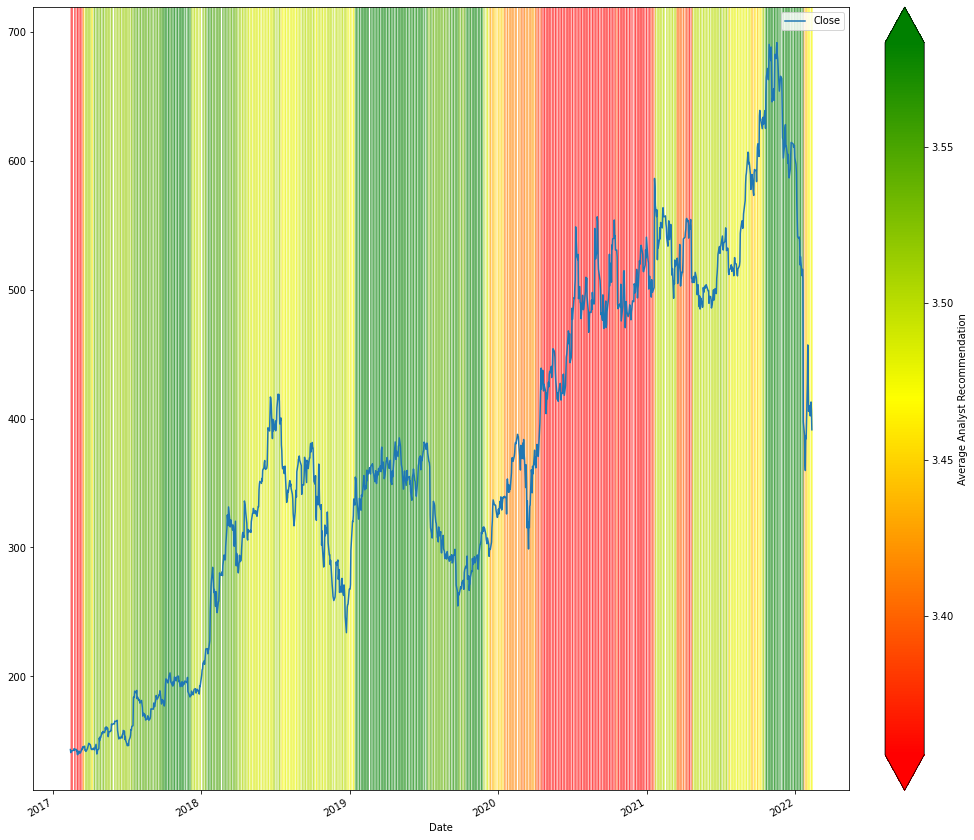

Correlation matrix for all data:


,Open,High,Low,Close,Volume,Average Assigned Value,Returns
Open,1.000000,0.999276,0.999213,0.998366,-0.222743,-0.285198,-0.036869
High,0.999276,1.000000,0.999025,0.999251,-0.210183,-0.289668,-0.016945
Low,0.999213,0.999025,1.000000,0.999238,-0.235644,-0.282960,-0.014633
Close,0.998366,0.999251,0.999238,1.000000,-0.220327,-0.287627,0.006756
Volume,-0.222743,-0.210183,-0.235644,-0.220327,1.000000,0.069886,0.001548
Average Assigned Value,-0.285198,-0.289668,-0.282960,-0.287627,0.069886,1.000000,-0.002881
Returns,-0.036869,-0.016945,-0.014633,0.006756,0.001548,-0.002881,1.000000


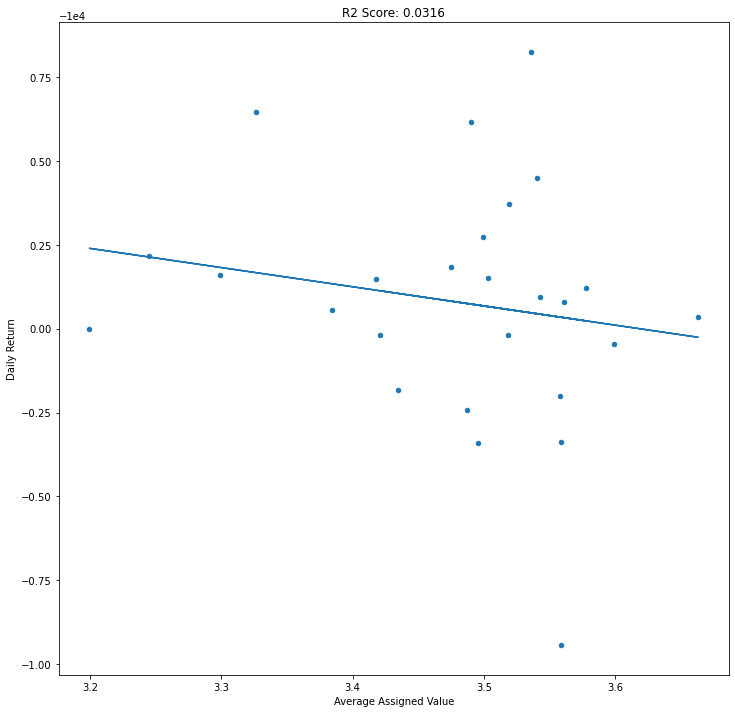

Correlation matrix for processed returns data:


,First Open,Last Close,Date,Average Assigned Value,Total Return Fraction,Daily Return
First Open,1.000000,0.886633,0.105079,-0.299219,-0.412598,-0.423575
Last Close,0.886633,1.000000,-0.011261,-0.443166,0.016658,0.022258
Date,0.105079,-0.011261,1.000000,-0.108649,-0.335681,-0.350636
Average Assigned Value,-0.299219,-0.443166,-0.108649,1.000000,-0.165193,-0.177858
Total Return Fraction,-0.412598,0.016658,-0.335681,-0.165193,1.000000,0.991013
Daily Return,-0.423575,0.022258,-0.350636,-0.177858,0.991013,1.000000


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Results for: GOOGL
Recommendation values: ['Buy', 'Hold', 'Market Outperform', 'Market Perform', 'Neutral', 'Outperform', 'Overweight', 'Positive', 'Underperform']


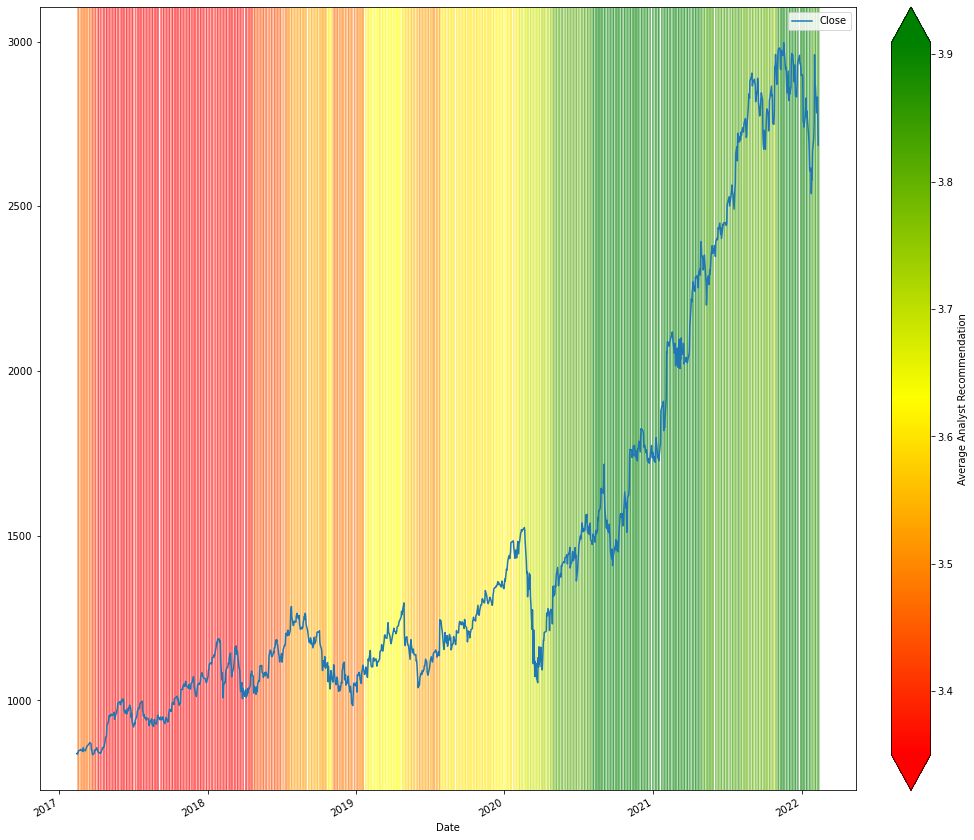

Correlation matrix for all data:


,Open,High,Low,Close,Volume,Average Assigned Value,Returns
Open,1.000000,0.999738,0.999691,0.999413,-0.109765,0.733333,0.005710
High,0.999738,1.000000,0.999606,0.999691,-0.102672,0.736469,0.015719
Low,0.999691,0.999606,1.000000,0.999734,-0.120191,0.731874,0.017822
Close,0.999413,0.999691,0.999734,1.000000,-0.112894,0.734180,0.029229
Volume,-0.109765,-0.102672,-0.120191,-0.112894,1.000000,-0.034839,-0.049349
Average Assigned Value,0.733333,0.736469,0.731874,0.734180,-0.034839,1.000000,0.022449
Returns,0.005710,0.015719,0.017822,0.029229,-0.049349,0.022449,1.000000


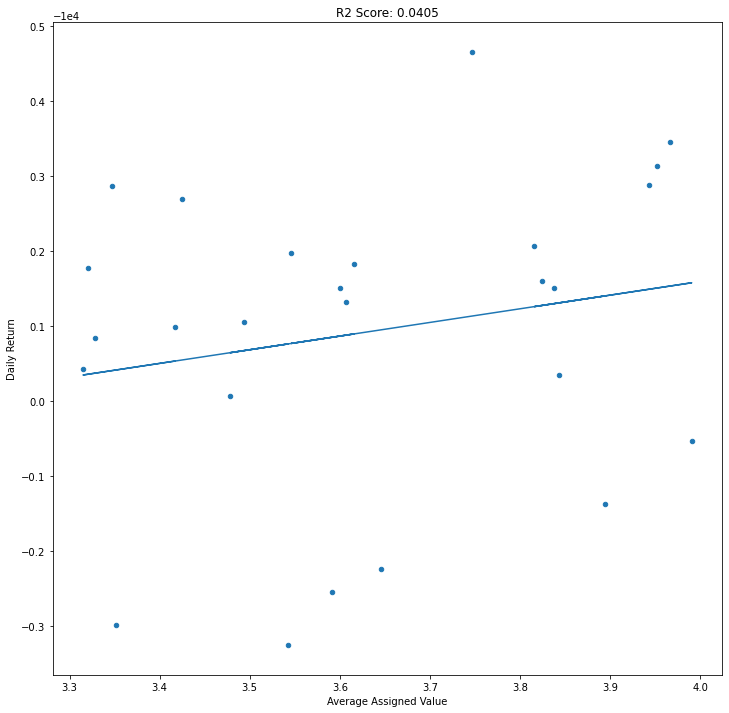

Correlation matrix for processed returns data:


,First Open,Last Close,Date,Average Assigned Value,Total Return Fraction,Daily Return
First Open,1.000000,0.972073,0.055834,0.709477,-0.043099,-0.034941
Last Close,0.972073,1.000000,0.064454,0.750837,0.181540,0.189022
Date,0.055834,0.064454,1.000000,0.057637,0.100571,0.073685
Average Assigned Value,0.709477,0.750837,0.057637,1.000000,0.206738,0.201261
Total Return Fraction,-0.043099,0.181540,0.100571,0.206738,1.000000,0.997794
Daily Return,-0.034941,0.189022,0.073685,0.201261,0.997794,1.000000


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Results for: DIS
Recommendation values: ['', 'Average', 'Buy', 'Equal-Weight', 'Equal-weight', 'Hold', 'In-Line', 'Long-Term Buy', 'Market Perform', 'Neutral', 'Outperform', 'Overweight', 'Sector Perform', 'Sell', 'Top Pick', 'Underperform', 'Underweight']


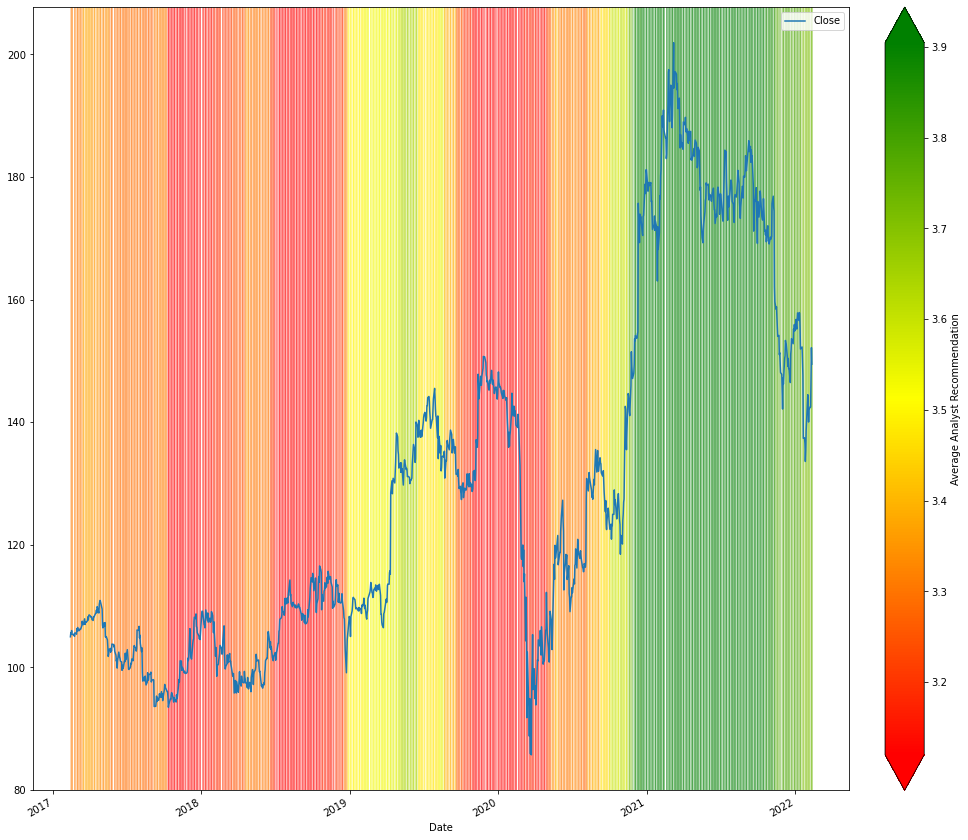

Correlation matrix for all data:


,Open,High,Low,Close,Volume,Average Assigned Value,Returns
Open,1.000000,0.999075,0.998994,0.998195,0.035402,0.766740,-0.007002
High,0.999075,1.000000,0.998471,0.999123,0.054065,0.768042,0.016592
Low,0.998994,0.998471,1.000000,0.998942,0.014912,0.766674,0.012290
Close,0.998195,0.999123,0.998942,1.000000,0.036947,0.768163,0.036915
Volume,0.035402,0.054065,0.014912,0.036947,1.000000,0.032115,0.105448
Average Assigned Value,0.766740,0.768042,0.766674,0.768163,0.032115,1.000000,0.014203
Returns,-0.007002,0.016592,0.012290,0.036915,0.105448,0.014203,1.000000


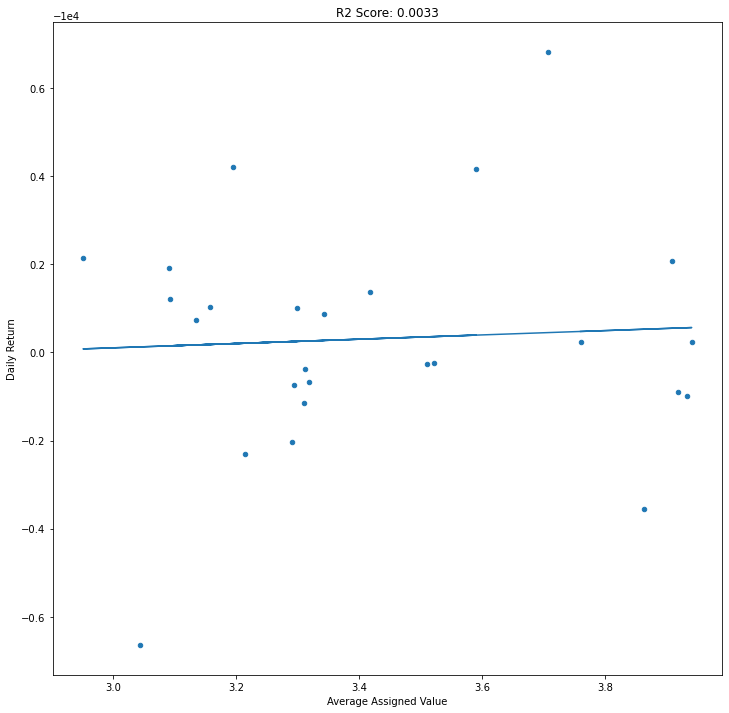

Correlation matrix for processed returns data:


,First Open,Last Close,Date,Average Assigned Value,Total Return Fraction,Daily Return
First Open,1.000000,0.843574,-0.073733,0.773116,-0.287484,-0.293034
Last Close,0.843574,1.000000,-0.042141,0.811120,0.264635,0.259161
Date,-0.073733,-0.042141,1.000000,0.106074,0.108420,0.084261
Average Assigned Value,0.773116,0.811120,0.106074,1.000000,0.055148,0.057878
Total Return Fraction,-0.287484,0.264635,0.108420,0.055148,1.000000,0.991784
Daily Return,-0.293034,0.259161,0.084261,0.057878,0.991784,1.000000


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Results for: CBRL
Recommendation values: ['Buy', 'Equal-Weight', 'Hold', 'Market Perform', 'Neutral', 'Outperform', 'Underperform', 'Underweight']


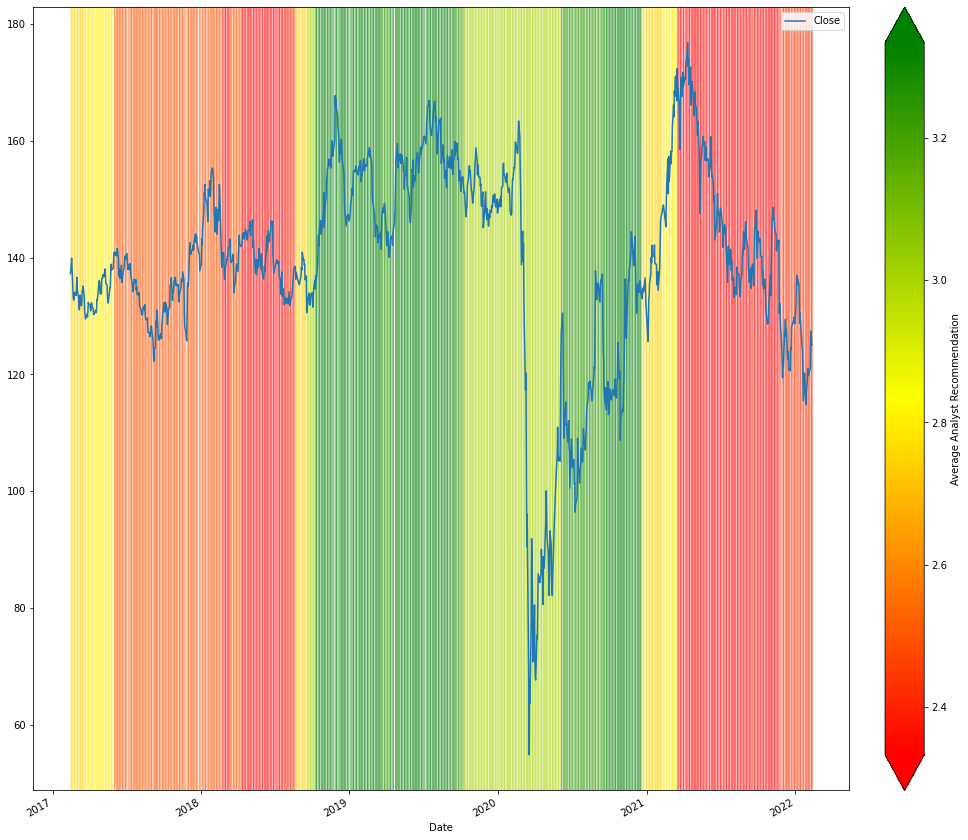

Correlation matrix for all data:


,Open,High,Low,Close,Volume,Average Assigned Value,Returns
Open,1.000000,0.995377,0.995110,0.990658,-0.342709,-0.007981,-0.057916
High,0.995377,1.000000,0.993816,0.994970,-0.311744,-0.003969,-0.001804
Low,0.995110,0.993816,1.000000,0.996271,-0.375127,-0.012698,0.001980
Close,0.990658,0.994970,0.996271,1.000000,-0.351658,-0.005746,0.053262
Volume,-0.342709,-0.311744,-0.375127,-0.351658,1.000000,0.239223,-0.040677
Average Assigned Value,-0.007981,-0.003969,-0.012698,-0.005746,0.239223,1.000000,0.027905
Returns,-0.057916,-0.001804,0.001980,0.053262,-0.040677,0.027905,1.000000


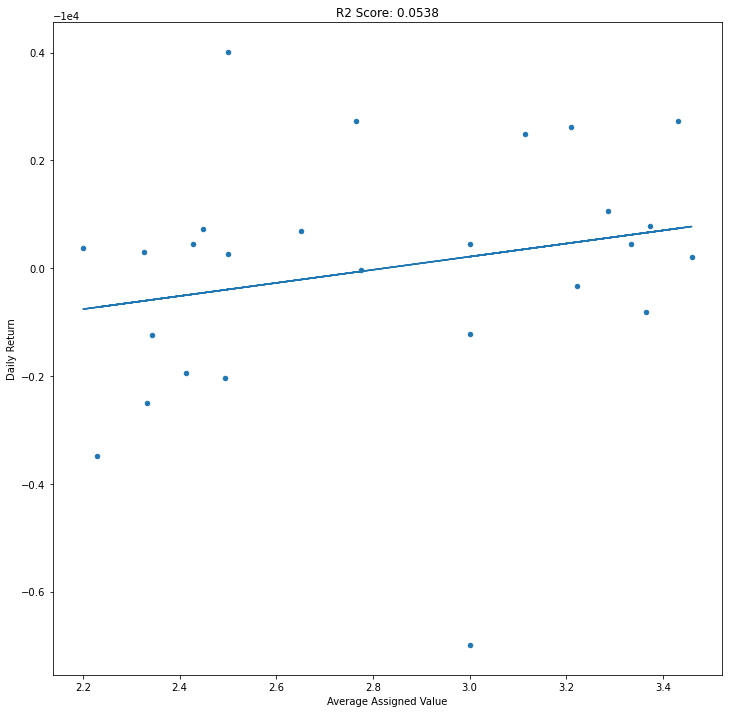

Correlation matrix for processed returns data:


,First Open,Last Close,Date,Average Assigned Value,Total Return Fraction,Daily Return
First Open,1.000000,0.668627,-0.248373,-0.141570,-0.493992,-0.471603
Last Close,0.668627,1.000000,-0.329172,0.048483,0.313494,0.337853
Date,-0.248373,-0.329172,1.000000,-0.123590,-0.088986,-0.080934
Average Assigned Value,-0.141570,0.048483,-0.123590,1.000000,0.251463,0.231986
Total Return Fraction,-0.493992,0.313494,-0.088986,0.251463,1.000000,0.996414
Daily Return,-0.471603,0.337853,-0.080934,0.231986,0.996414,1.000000


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Results for: HBI
Recommendation values: ['Buy', 'Equal-Weight', 'Hold', 'Market Perform', 'Neutral', 'Outperform', 'Overweight', 'Perform', 'Sell', 'Strong Buy', 'Underperform', 'Underweight']


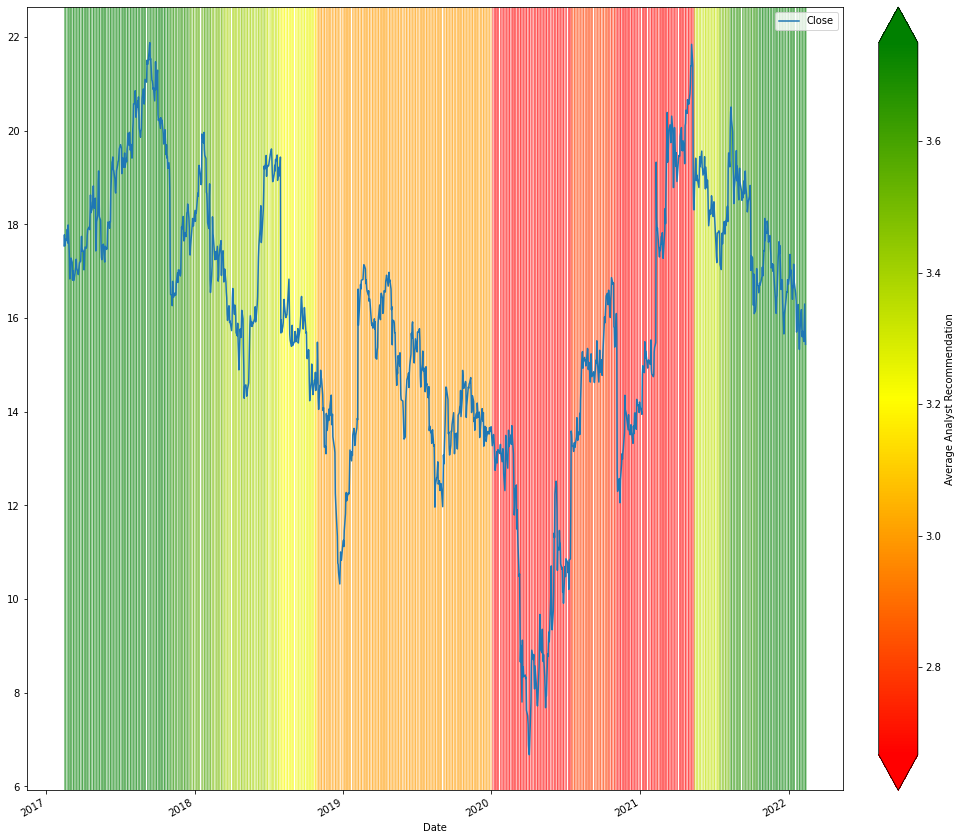

Correlation matrix for all data:


,Open,High,Low,Close,Volume,Average Assigned Value,Returns
Open,1.000000,0.997185,0.996894,0.993863,-0.290021,0.684657,-0.031221
High,0.997185,1.000000,0.996302,0.996905,-0.267596,0.680849,0.010486
Low,0.996894,0.996302,1.000000,0.997392,-0.312741,0.687918,0.014591
Close,0.993863,0.996905,0.997392,1.000000,-0.292659,0.682007,0.056957
Volume,-0.290021,-0.267596,-0.312741,-0.292659,1.000000,-0.203749,-0.042333
Average Assigned Value,0.684657,0.680849,0.687918,0.682007,-0.203749,1.000000,-0.023536
Returns,-0.031221,0.010486,0.014591,0.056957,-0.042333,-0.023536,1.000000


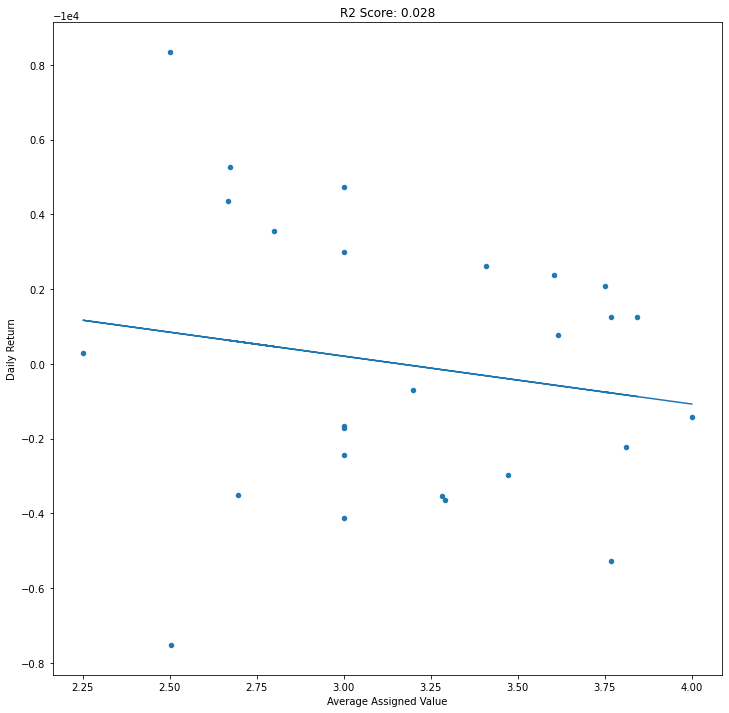

Correlation matrix for processed returns data:


,First Open,Last Close,Date,Average Assigned Value,Total Return Fraction,Daily Return
First Open,1.000000,0.637492,0.123251,0.746882,-0.473507,-0.438624
Last Close,0.637492,1.000000,0.050735,0.597944,0.347639,0.393024
Date,0.123251,0.050735,1.000000,0.143779,-0.038019,-0.037363
Average Assigned Value,0.746882,0.597944,0.143779,1.000000,-0.218631,-0.167226
Total Return Fraction,-0.473507,0.347639,-0.038019,-0.218631,1.000000,0.993688
Daily Return,-0.438624,0.393024,-0.037363,-0.167226,0.993688,1.000000


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Results for: XOM
Recommendation values: ['Buy', 'Equal-Weight', 'Hold', 'Market Perform', 'Neutral', 'Outperform', 'Overweight', 'Perform', 'Reduce', 'Sector Outperform', 'Sector Perform', 'Sector Underperform', 'Sell', 'Strong Buy', 'Underperform', 'Underweight']


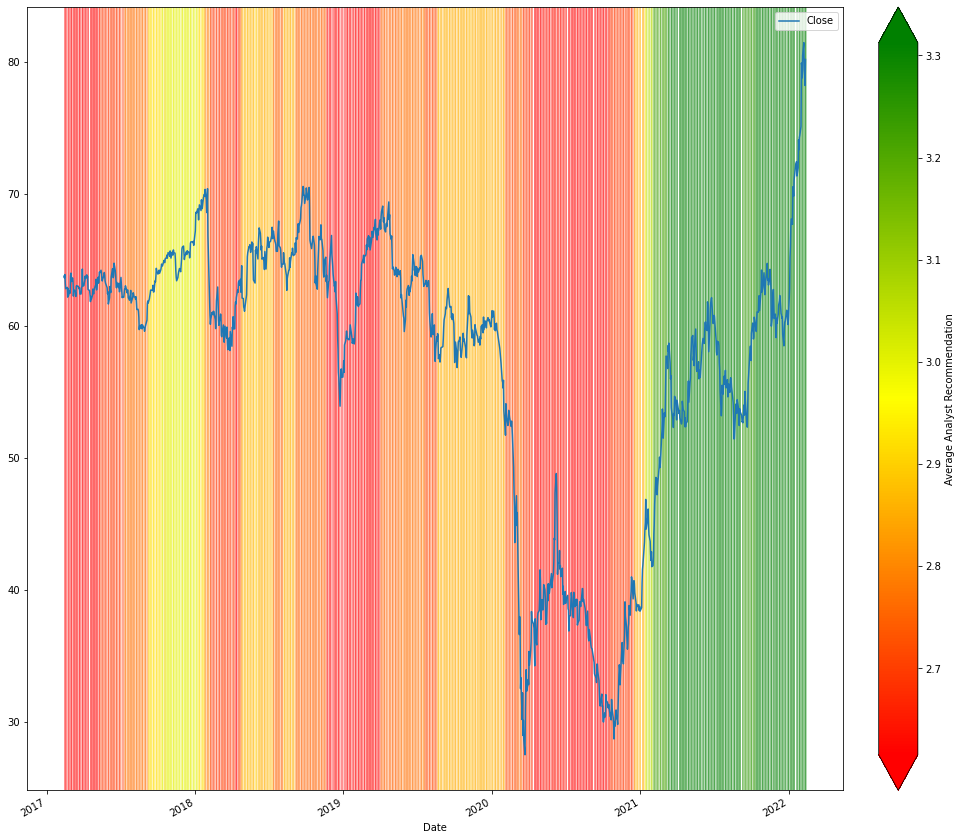

Correlation matrix for all data:


,Open,High,Low,Close,Volume,Average Assigned Value,Returns
Open,1.000000,0.998952,0.998880,0.997734,-0.588693,0.257966,-0.004799
High,0.998952,1.000000,0.998532,0.998943,-0.573593,0.268394,0.018486
Low,0.998880,0.998532,1.000000,0.998938,-0.603926,0.254555,0.019441
Close,0.997734,0.998943,0.998938,1.000000,-0.587835,0.263172,0.044325
Volume,-0.588693,-0.573593,-0.603926,-0.587835,1.000000,0.180603,0.016176
Average Assigned Value,0.257966,0.268394,0.254555,0.263172,0.180603,1.000000,0.059636
Returns,-0.004799,0.018486,0.019441,0.044325,0.016176,0.059636,1.000000


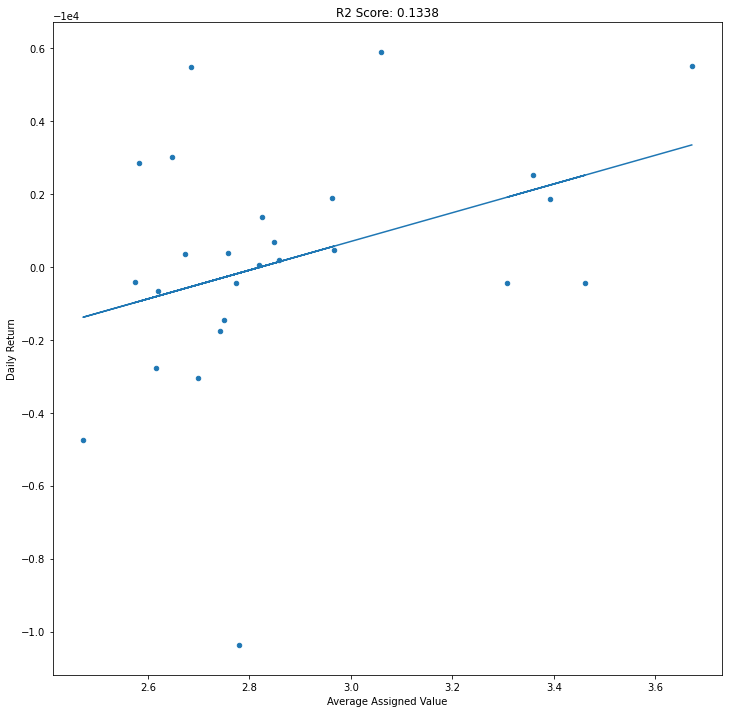

Correlation matrix for processed returns data:


,First Open,Last Close,Date,Average Assigned Value,Total Return Fraction,Daily Return
First Open,1.000000,0.726130,-0.124709,0.083627,-0.386012,-0.337984
Last Close,0.726130,1.000000,-0.048106,0.392985,0.335575,0.385303
Date,-0.124709,-0.048106,1.000000,0.029697,0.074756,0.076553
Average Assigned Value,0.083627,0.392985,0.029697,1.000000,0.382365,0.365791
Total Return Fraction,-0.386012,0.335575,0.074756,0.382365,1.000000,0.989786
Daily Return,-0.337984,0.385303,0.076553,0.365791,0.989786,1.000000


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [6]:
for i in stock_tickers:
    process_individual_stock(i)
#     process_individual_stock(i,returns_method='Recommendation Moves')